# Assignment 1: Comparison of Regression Models on Predicting Medical Costs

### CS 4774 Machine Learning - Department of Computer Science - University of Virginia
![Medical Cost](https://creditkarma-cms.imgix.net/wp-content/uploads/2018/04/boomers-gen-x-high-cost-medical-care.jpg)
In this assignment, you will implement some learning models in the context of a **regression** problem in the [Medical Cost Personal Dataset on Kaggle](https://www.kaggle.com/mirichoi0218/insurance). Specifically, you will attempt to predict the medical cost billed by health insurance using other provided patient's data. For references, you may refer to [my slides](https://docs.google.com/presentation/d/10D1he89peAWaFgjtZlHpUzvOOAie_vIFT95htKCKgc0/edit#slide=id.p) or the Google Colab if you need additional sample codes to help with your assignment. To get started, you will need to upload/copy the dataset (.csv) into the same folder as this file. 

For deliverables, you must write code in Colab and submit the downloaded Jupyter Notebook file (.ipynb) to earn a total of 100 pts. You will gain points depending on how you perform in the following sections.


***
##  Task 1: SEE THE BIG PICTURE (5 pts)
Write a paragraph explaining the context of the problem in which you are trying to investigate. We will assume that the data file is put into the same workspace on Colab. Then, you can write some code to load the CSV file and take a quick look at the dataset, and output the following:

 * How big is your dataset? (in terms of MB)
 * How many entries does it have?
 * How many features does it have?
 * Does it contain any categorical data?
 * Is there any missing value?
 * What are some basic statistics you can learn right away about this dataset?

In [ ]:
# Import some common packages
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

In [ ]:
# Steps from here
# 1 - sign into kaggle
# 2 - click on 'my account'
# 3 - scroll down to the API section and click get token
# 4 - run this cell and click on the kaggle.json file that should now be in downloads

# Upload kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# move the authentication key
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
# call the kaggle API to get the boston housing data
!kaggle datasets download -d mirichoi0218/insurance

# unzip and move to proper folder
import zipfile
with zipfile.ZipFile('/content/insurance.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/datasets/insurance')

insurance.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
INSURANCE_PATH = '/content/datasets/insurance/'

insurance = pd.read_csv(INSURANCE_PATH + "insurance.csv")

In [ ]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
# What are some basic statistics you can learn right away?
insurance.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [ ]:
# What is the size of this dataset?
insurance.memory_usage()

Index         128
age         10704
sex         10704
bmi         10704
children    10704
smoker      10704
region      10704
charges     10704
dtype: int64

In [ ]:
# How many features are there? - 7
insurance.axes

[RangeIndex(start=0, stop=1338, step=1),
 Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')]

In [ ]:
# Does the dataset contain any categorical features? - yes
insurance.info

<bound method DataFrame.info of       age     sex     bmi  children smoker     region      charges
0      19  female  27.900         0    yes  southwest  16884.92400
1      18    male  33.770         1     no  southeast   1725.55230
2      28    male  33.000         3     no  southeast   4449.46200
3      33    male  22.705         0     no  northwest  21984.47061
4      32    male  28.880         0     no  northwest   3866.85520
...   ...     ...     ...       ...    ...        ...          ...
1333   50    male  30.970         3     no  northwest  10600.54830
1334   18  female  31.920         0     no  northeast   2205.98080
1335   18  female  36.850         0     no  southeast   1629.83350
1336   21  female  25.800         0     no  southwest   2007.94500
1337   61  female  29.070         0    yes  northwest  29141.36030

[1338 rows x 7 columns]>

In [ ]:
# Are there any missing values? - No
insurance.isna

<bound method DataFrame.isna of       age     sex     bmi  children smoker     region      charges
0      19  female  27.900         0    yes  southwest  16884.92400
1      18    male  33.770         1     no  southeast   1725.55230
2      28    male  33.000         3     no  southeast   4449.46200
3      33    male  22.705         0     no  northwest  21984.47061
4      32    male  28.880         0     no  northwest   3866.85520
...   ...     ...     ...       ...    ...        ...          ...
1333   50    male  30.970         3     no  northwest  10600.54830
1334   18  female  31.920         0     no  northeast   2205.98080
1335   18  female  36.850         0     no  southeast   1629.83350
1336   21  female  25.800         0     no  southwest   2007.94500
1337   61  female  29.070         0    yes  northwest  29141.36030

[1338 rows x 7 columns]>

Given client personal information such as age, sex, bmi, children, smoker, and region of the country, the job is to estimate the expected cost of their insurance. I suspect age, smoker, and bmi will hold the most weight.

---
##  Task 2: DATA DISCOVERY, CLEANING, AND SCALING (25 pts)

**Data Discover:** Plot out all correlations among the features. You may notice some features are more correlated with your predicted value than other. This information will help you confirm that weights of your regression model later on.

**Data Cleaning:** If your dataset has some missing values, make sure you are able to fill those values with the Imputer class. If your dataset has categorical features, make sure you conver those features into numerical using OneHotEncoder class. 

**Feature Scaling** More importantly, your task is to write some codes to normalize the value of each features as follow:

* Subtract the mean value of each feature from the dataset
* Scale (divide) the feature values by their respective standard deviation

**Implementation Note:** You will need to integrate the above operations into a Pipeline to process and transform the training data, then use the same pipeline to transform any validation and testing data.

In [ ]:
# You might want to use the following package
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix # optional
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
# first I'm going to transform the data so that I can do visualizations of all features 
# (categorical wouldnt show up if I plotted a correlation map right now)
encoder = LabelEncoder()
encoder.fit(insurance['smoker'].drop_duplicates())

LabelEncoder()

In [ ]:
# fit the smoker feature into the label encoder which will change the yes/no to a binary 1/0
insurance['smoker'] = encoder.transform(insurance['smoker'])

In [ ]:
insurance['smoker']

0       1
1       0
2       0
3       0
4       0
       ..
1333    0
1334    0
1335    0
1336    0
1337    1
Name: smoker, Length: 1338, dtype: int64

In [ ]:
# repeat the same thing for sex
encoder.fit(insurance['sex'].drop_duplicates())
insurance['sex'] = encoder.transform(insurance['sex'])

In [ ]:
insurance['sex']

0       0
1       1
2       1
3       1
4       1
       ..
1333    1
1334    0
1335    0
1336    0
1337    0
Name: sex, Length: 1338, dtype: int64

In [ ]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,southwest,16884.92400
1,18,1,33.770,1,0,southeast,1725.55230
2,28,1,33.000,3,0,southeast,4449.46200
3,33,1,22.705,0,0,northwest,21984.47061
4,32,1,28.880,0,0,northwest,3866.85520


In [ ]:
# I'll leave region to be OneHotEncoded later because I feel it will be too broad to represent in a correlation map

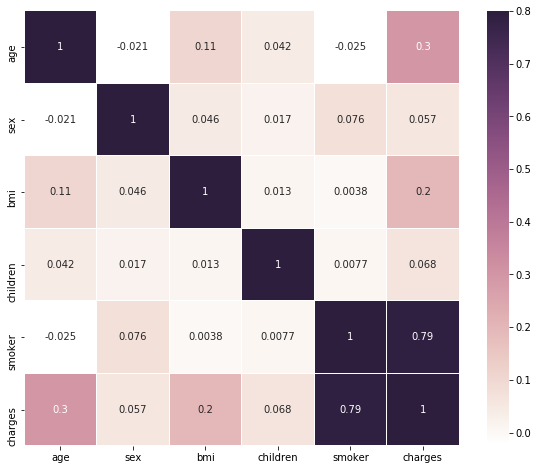

In [ ]:
# next I'm going to do the visualizations
# plot a correlation matrix that is easy to read
import seaborn as sns
corr_matrix = insurance.corr()
plt.figure(figsize=(10, 8))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.heatmap(corr_matrix, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap=cmap,linecolor="white")

Smoker is the only feature strongly correlated with charges

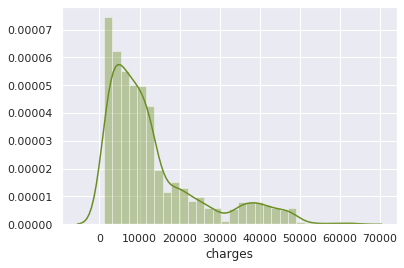

In [ ]:
# plot distributions
sns.set()
sns.distplot(insurance['charges'], color="olivedrab")

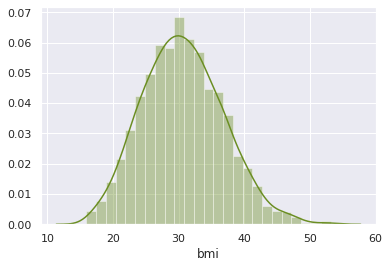

In [ ]:
sns.distplot(insurance['bmi'], color="olivedrab")

BMI is normally distributed

The charges skew to the right

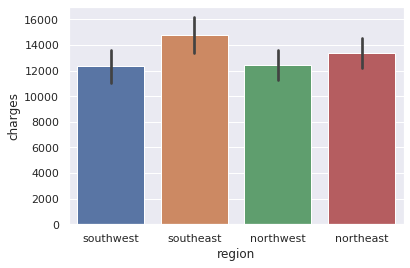

In [ ]:
# lets see which regions have the highest charges
sns.barplot(x="region", y="charges", data=insurance)

The southeast seems to have higher charges.

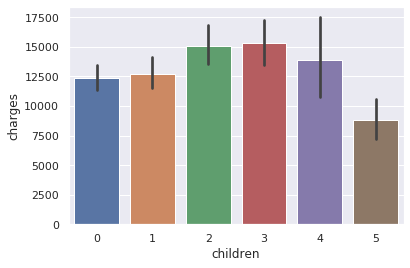

In [ ]:
sns.barplot(x="children", y="charges", data=insurance)

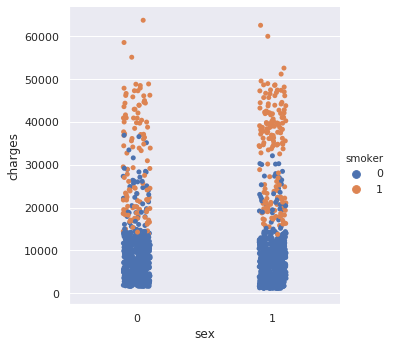

In [ ]:
# Let's plot out a similar chart between male and female
# women are 1 and men are 0
sns.catplot(x="sex", y="charges", hue="smoker", data=insurance)

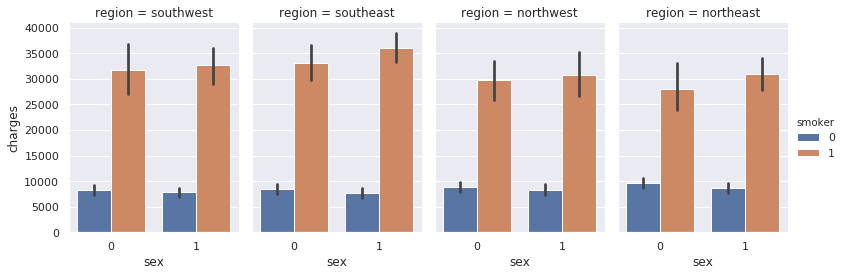

In [ ]:
# combine the 2 plots to include region
sns.catplot(x="sex", y="charges", hue="smoker", col="region", data=insurance, kind="bar", height=4, aspect=.7)

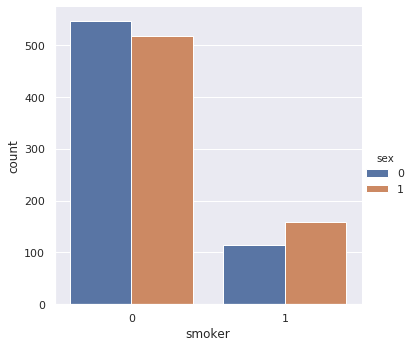

In [ ]:
# what is the ratio of smokers to non smokers?
sns.catplot(x="smoker", kind="count", hue="sex", data=insurance)

There are about 5X more nonsmokers than smokers. I can dive deeper into smoking to see if it is normally distributed

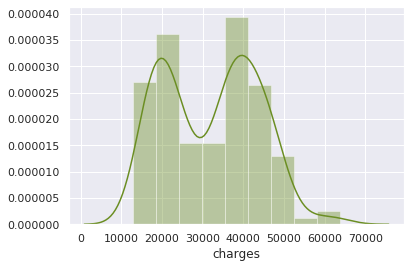

In [ ]:
sns.distplot(insurance[(insurance["smoker"] == 1)]["charges"], color="olivedrab")

The dip in the middle is weird, it might have to do with age or bmi.

---



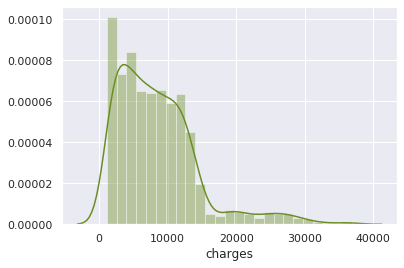

In [ ]:
sns.distplot(insurance[(insurance["smoker"] == 0)]["charges"], color="olivedrab")

Non smokers are more evenly distributed

In [ ]:
# Check to see if there's any missing value in the data with .isnull()
sample_incomplete_rows = insurance[insurance.isnull().any(axis=1)].head()
sample_incomplete_rows

,age,sex,bmi,children,smoker,region,charges


In [ ]:
# Start creating the data transformation pipeline
num_feats = ["age", "bmi", "children", "smoker", "sex"]
cat_feats = ["region"] 

In [ ]:
insurance.shape

(1338, 7)

In [ ]:
#features array
x = insurance.drop("charges", axis=1)

In [ ]:
# label array
y = insurance["charges"]

In [ ]:
# pipeline for the feature number columns
num_pipeline = Pipeline([
      ('std_scaler', StandardScaler()),
  ])

In [ ]:
from sklearn.compose import ColumnTransformer

# full pipeline that oneHotEncodes categorical feats
# and standard scales numerical
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_feats),
        ("cat", OneHotEncoder(), cat_feats),
  ])

In [ ]:
x = full_pipeline.fit_transform(x)

In [ ]:
# Your code goes here for this section.
X_train = [];
y_train = [];
X_test = [];
y_test = [];

X_train, X_test, y_train, y_test = train_test_split(x,y, random_state=0)

In [ ]:
X_train

array([[-0.51314879, -0.17608483, -0.07876719, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.55168573, -1.41462066, -0.90861367, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43876426, -0.99466679, -0.07876719, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.05646073, -0.91592544, -0.90861367, ...,  0.        ,
         1.        ,  0.        ],
       [-1.43876426,  0.79833938, -0.90861367, ...,  1.        ,
         0.        ,  0.        ],
       [-0.4419476 , -1.99533811, -0.07876719, ...,  0.        ,
         0.        ,  1.        ]])

In [ ]:
X_test

array([[ 0.91087502, -0.0760177 , -0.07876719, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.55486907, -0.21217462, -0.07876719, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.62607026,  1.62430334,  0.75107928, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 0.83967383, -0.10390526, -0.07876719, ...,  0.        ,
         1.        ,  0.        ],
       [-1.1539595 ,  1.05588922,  1.58092576, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.55168573, -0.26138796, -0.90861367, ...,  1.        ,
         0.        ,  0.        ]])

In [ ]:
y_test = np.asarray(y_test)
y_train = np.asarray(y_train)

In [ ]:
shape = (len(y_train), 1)
y_train = y_train.reshape(shape)

shape1 = (len(y_test), 1)
y_test = y_test.reshape(shape1)

In [ ]:
y_train

array([[ 4562.8421],
       [13616.3586],
       [ 1837.237 ],
       ...,
       [ 5415.6612],
       [ 1646.4297],
       [ 4766.022 ]])

In [ ]:
y_test

array([[ 9724.53    ],
       [ 8547.6913  ],
       [45702.02235 ],
       [12950.0712  ],
       [ 9644.2525  ],
       [ 4500.33925 ],
       [ 2198.18985 ],
       [11436.73815 ],
       [ 7537.1639  ],
       [ 5425.02335 ],
       [ 6753.038   ],
       [10493.9458  ],
       [ 7337.748   ],
       [ 4185.0979  ],
       [18310.742   ],
       [10702.6424  ],
       [12523.6048  ],
       [ 3490.5491  ],
       [ 6457.8434  ],
       [33475.81715 ],
       [23967.38305 ],
       [12643.3778  ],
       [23045.56616 ],
       [23065.4207  ],
       [ 1674.6323  ],
       [ 4667.60765 ],
       [ 3732.6251  ],
       [ 7682.67    ],
       [ 3756.6216  ],
       [ 8413.46305 ],
       [ 8059.6791  ],
       [48970.2476  ],
       [12979.358   ],
       [20630.28351 ],
       [14571.8908  ],
       [ 4137.5227  ],
       [ 8347.1643  ],
       [51194.55914 ],
       [40003.33225 ],
       [ 1880.487   ],
       [ 5458.04645 ],
       [ 2867.1196  ],
       [20149.3229  ],
       [474

In [ ]:
y_train.shape

(1003, 1)

In [ ]:
y_test.shape

(335, 1)

- - -
## Task 3. IMPLEMENT GRADIENT DESCENT (30 pts)
The gradient descent formulation remain the same as one in the lecture. Keep in mind that you will need to add a column $\textbf{x}_0$ with all 1s as part of the training data. You should write code to implement the **MyLinearRegression** class and its predefined methods. 

**Gradient Descent:** Notes that you may NOT call the library linear regression which defeats the purpose of this assignment. Make sure your code is well-vectorized.

In [ ]:
# NOTE: You may not use the library Linear Regression, but implement your own!
# REMEMBER to place self.attribute = 0 with value from your implementation

class MyLinearRegression:
  """
  Define what a linear regressor can do
  """

  def __init__ (self, alpha):
    """
    Initialize the regressor
    """
    self.theta = 0; # parameter vector;
    self.alpha = alpha; # learning rate
    self.iters = 1000
    self.cost_array  = np.zeros(self.iters)


  def cost(self, theta, X_train, y_train):
    # where m = number of examples
    # first define m and then create the cost function
    m = len(y_train)

    # add column of 1's to x0
    X_0 = np.c_[np.ones((m,1)), X_train]

    s = X_0.dot(self.theta) - y_train
    cost = (1/m)*s.T.dot(s)
    return cost

  def gradientDescent(self, X_train, y_train, theta, alpha, iters):
    """
    Implementatation of the gradient descent
    INPUT:
    alpha: the learning rate
    iters: number of iterations

    OUTPUT: 
    theta: updated value for theta
    cost: value of the cost function
    """
    # each Gradient step --> theta = theta - alph
    # first define m 
    m = len(y_train)
    cost_array = np.zeros(iters)
    self.theta = np.random.randn(10,1)
    X_0 = np.c_[np.ones((m,1)), X_train]
    for it in range(iters):
      grad = 2/m * X_0.T.dot(X_0.dot(self.theta) - y_train)
      self.theta = self.theta - self.alpha * grad
      self.cost_array[it] = cost(self.theta, X_train, y_train)

  def fitUsingNormalEquation(self, X_train, y_train):
    """
    Training using the Normal (close form) equation
    """
    # implementation code here for Task 4.
    m = len(y_train)
    X_0 = np.c_[np.ones((m,1)), X_train]
    self.theta = np.linalg.inv(X_0.T.dot(X_0)).dot(X_0.T).dot(y_train);

  def predict(self, X_test):
    """
    Predicting the label
    """
    test_size = len(X_test)
    X_0 = np.c_[np.ones((test_size,1)), X_test]
    y_predict = np.dot(X_0, self.theta)
    # implementation code here 
    return y_predict

  def __str__(self):
    """
    Print out the parameter out when call print()
    """
    # implement here to return("Parameter vector is %f" % self.theta)   }
    return 'Parameter vector is {}'.format(self.theta)
# Your code goes here to call the instance of class MyLinearRegression
myGradientDescentModel = MyLinearRegression(0.1)   

In [ ]:
myGradientDescentModel.gradientDescent(X_train, y_train,myGradientDescentModel.theta,0.1,1000)    

In [ ]:
predict = myGradientDescentModel.predict(X_test)

In [ ]:
predict

array([[11121.10140924],
       [ 9369.08345223],
       [38349.2588068 ],
       [16331.93500645],
       [ 7041.22770615],
       [ 4103.24923177],
       [ 1734.03805961],
       [14478.86491464],
       [ 9168.77981235],
       [ 7715.94671029],
       [ 4625.04765547],
       [10398.53755318],
       [ 8756.48015868],
       [ 3738.25833927],
       [28190.41129687],
       [10600.67828764],
       [11395.63055992],
       [ 6248.83935385],
       [ 8423.19721152],
       [27360.73273479],
       [33843.62542848],
       [14432.50562897],
       [11759.04359894],
       [32070.2132407 ],
       [ 4152.83526684],
       [ 9364.57488075],
       [ 1227.5561631 ],
       [ 9712.31328139],
       [ 3714.56843696],
       [10585.88359557],
       [ 9162.47300707],
       [39963.69536536],
       [15580.1455371 ],
       [13795.75096539],
       [24960.11670118],
       [ 5274.13784945],
       [12507.41956494],
       [30840.51073591],
       [33738.39701967],
       [ 3693.97640602],


In [ ]:
print(myGradientDescentModel)

Parameter vector is [[1.06309131e+04]
 [3.51331385e+03]
 [2.03174621e+03]
 [5.32886230e+02]
 [9.54646722e+03]
 [6.63117321e+00]
 [3.19278254e+03]
 [2.99964961e+03]
 [2.11298089e+03]
 [2.32433883e+03]]


In [ ]:
myGradientDescentModel.cost_array

array([2.04204222e+08, 1.37413466e+08, 9.78683839e+07, 7.43272702e+07,
       6.02312780e+07, 5.17377815e+07, 4.65854067e+07, 4.34369499e+07,
       4.14976500e+07, 4.02925909e+07, 3.95363715e+07, 3.90564629e+07,
       3.87479269e+07, 3.85465300e+07, 3.84126970e+07, 3.83218797e+07,
       3.82587450e+07, 3.82136461e+07, 3.81804670e+07, 3.81552986e+07,
       3.81356201e+07, 3.81197893e+07, 3.81067246e+07, 3.80957037e+07,
       3.80862373e+07, 3.80779872e+07, 3.80707155e+07, 3.80642502e+07,
       3.80584642e+07, 3.80532606e+07, 3.80485637e+07, 3.80443127e+07,
       3.80404578e+07, 3.80369568e+07, 3.80337740e+07, 3.80308780e+07,
       3.80282416e+07, 3.80258405e+07, 3.80236529e+07, 3.80216594e+07,
       3.80198425e+07, 3.80181863e+07, 3.80166765e+07, 3.80153000e+07,
       3.80140450e+07, 3.80129008e+07, 3.80118575e+07, 3.80109062e+07,
       3.80100387e+07, 3.80092477e+07, 3.80085265e+07, 3.80078688e+07,
       3.80072690e+07, 3.80067221e+07, 3.80062234e+07, 3.80057687e+07,
      

* **Learning Rate:** You will try out different learning rates for the dataset and find a learning rate that converges quickly. If you pick a learning rate, your plot of Cost Function $J(\theta)$ against number of iteration will quickly decay to a small value. This also indicates that your implementation is correct. If your learning rate is too large, the cost function $J(\theta)$ can diverge and blow up. From the below plot, you must be able to report the best learning rate the you found to earn credit for this section.

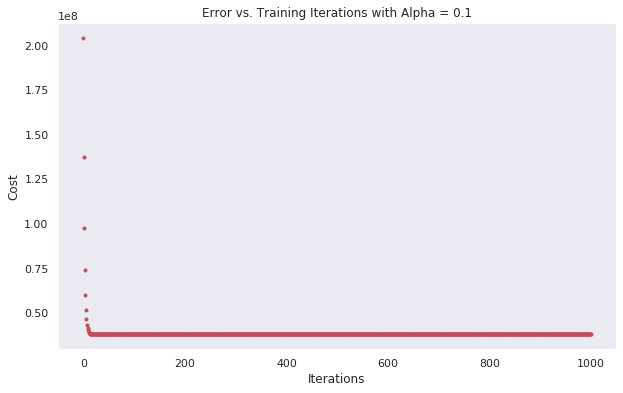

In [ ]:
# Use the following code to plot out your learning rate
# iters and cost must be supplied to plot out the cost function
# You may plot multiple curves corresponding to different learning rates to justify the best one.
#
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('Iterations')  
ax.set_ylabel('Cost')  
ax.set_title('Error vs. Training Iterations with Alpha = 0.1')
ax.grid(axis='both')
_=ax.plot(range(1000), myGradientDescentModel.cost_array, 'r.')  

In [ ]:
alpha05 = MyLinearRegression(0.05)

In [ ]:
alpha05.gradientDescent(X_train, y_train,myGradientDescentModel.theta,0.05,1000)    

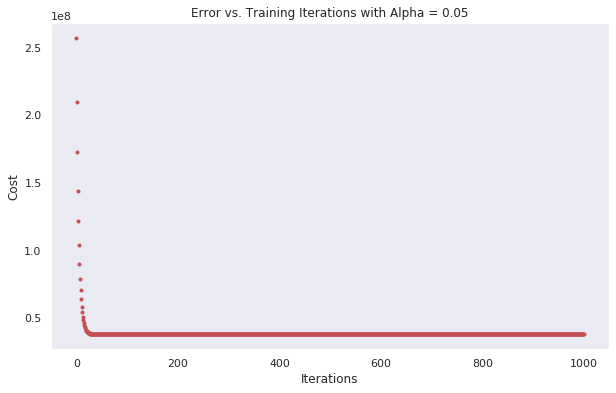

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('Iterations')  
ax.set_ylabel('Cost')  
ax.set_title('Error vs. Training Iterations with Alpha = 0.05')
ax.grid(axis='both')
_=ax.plot(range(1000), alpha05.cost_array, 'r.')  

In [ ]:
alpha02 = MyLinearRegression(0.02)
alpha02.gradientDescent(X_train, y_train,myGradientDescentModel.theta,0.02,1000) 

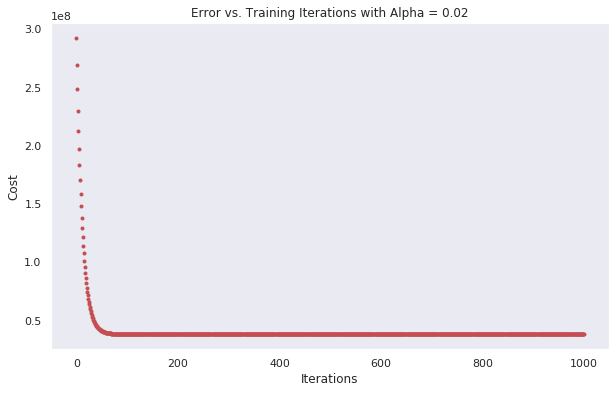

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('Iterations')  
ax.set_ylabel('Cost')  
ax.set_title('Error vs. Training Iterations with Alpha = 0.02')
ax.grid(axis='both')
_=ax.plot(range(1000), alpha02.cost_array, 'r.') 

In [ ]:
alpha01 = MyLinearRegression(0.01)
alpha01.gradientDescent(X_train, y_train,myGradientDescentModel.theta,0.01,1000)

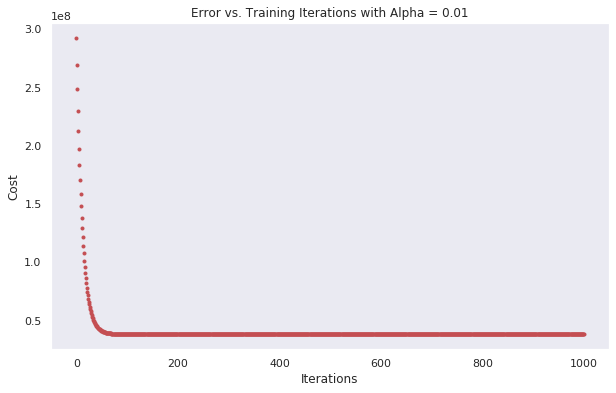

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('Iterations')  
ax.set_ylabel('Cost')  
ax.set_title('Error vs. Training Iterations with Alpha = 0.01')
ax.grid(axis='both')
_=ax.plot(range(1000), alpha02.cost_array, 'r.') 

All learning rates I tested seemed to converge very quick - although the error is still quite large. I believe alpha = 0.02 will work the best.

- - -
## Task 4. IMPLEMENT THE NORMAL EQUATION (10 pts)

In my lecture, you learn that the closed form solution of linear regression using the normal equation formulation. Using the formula does not require any feature scaling, and should be straight forward to implement: 

$
    \mathbf{\theta} = ({\mathbf{X}^{T}\mathbf{X}})^{-1}\mathbf{X}^{T}\mathbf{y}.
$

Note that you still need to add a column of 1's to the $\mathbf{
X}$ matrix to have an intercept term.

In [ ]:
# Implement the normalEquation method of the MyLinearRegression Class before execute the code below:
myNormalEquationModel = MyLinearRegression(0.02)
myNormalEquationModel.fitUsingNormalEquation(X_train, y_train)

- - -
## Task 5. COMPARE DIFFERENT IMPLEMENTATIONS (20 pts)

You should be able to evaluate and compare your gradient descent as well as normal equation implementation of linear regression. In theory, they should be the same, or at least similar. For good measures, you may also use the built-in library **Scholastic Gradient Descent (SGD)** as a third model for comparison. For each model, you must compute the RMSE on the **test set** as performance measure. The good news is that you can call library functions to compute these as shown below instead of writing your own code:

* Which one yields the best performance measure for your dataset?
* What is your assessment of the error? Good? Okay? Terrible?

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# Use the built-in SGD Regressor model
from sklearn.linear_model import SGDRegressor
mySGDModel = SGDRegressor()
mySGDModel.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [ ]:
y_predict = mySGDModel.predict(X_test)
mse = mean_squared_error(y_test, y_predict)
mySGDModel_rmse = np.sqrt(mse)
print(mySGDModel_rmse)

5664.397728462174


In [ ]:
rSGD = r2_score(y_test, y_predict)

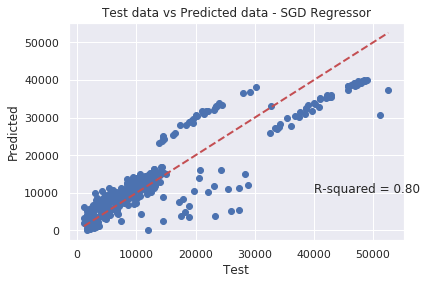

In [ ]:
# plotting y_test vs y_predict for random for SGD regressor
sns.set_style("darkgrid")
plt.scatter(y_test, y_predict)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.text(40000, 10000, 'R-squared = %0.2f' % rSGD)
plt.xlabel('Test')
plt.ylabel('Predicted')
plt.title('Test data vs Predicted data - SGD Regressor')
plt.show()

In [ ]:
# gradient descent rsme  
y_pred = alpha02.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
myGradientDescentModel_rmse = np.sqrt(mse)
print(myGradientDescentModel_rmse)

5668.837041423854


In [ ]:
rMGD = r2_score(y_test, y_pred)

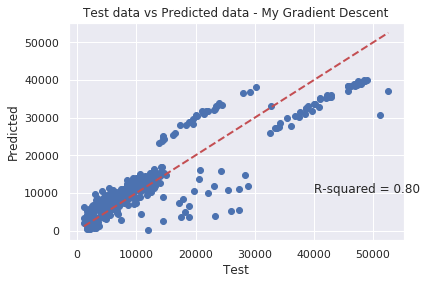

In [ ]:
# plotting y_test vs y_predict for random for SGD regressor
sns.set_style("darkgrid")
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.text(40000, 10000, 'R-squared = %0.2f' % rMGD)
plt.xlabel('Test')
plt.ylabel('Predicted')
plt.title('Test data vs Predicted data - My Gradient Descent')
plt.show()

In [ ]:
# normal equation rsme
y_pred1 = myNormalEquationModel.predict(X_test)
mse = mean_squared_error(y_test, y_pred1)
myNormalEquationModel_rmse = np.sqrt(mse)
print(myNormalEquationModel_rmse)

32487.176218475823


In [ ]:
rNO = r2_score(y_test, y_pred1)

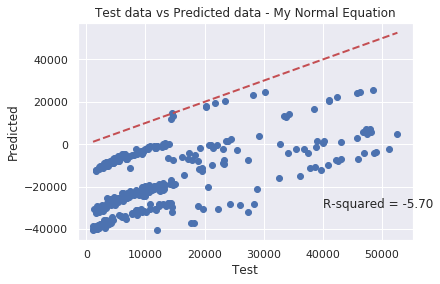

In [ ]:
# plotting y_test vs y_predict for random for SGD regressor
sns.set_style("darkgrid")
plt.scatter(y_test, y_pred1)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.text(40000, -30000, 'R-squared = %0.2f' % rNO)
plt.xlabel('Test')
plt.ylabel('Predicted')
plt.title('Test data vs Predicted data - My Normal Equation')
plt.show()

In [ ]:
# my gradient descent seems to perform the best
# I'll print out a confidence interval
from scipy import stats
error = (y_pred-y_test)**2
v = len(error) - 1
np.sqrt(stats.t.interval(0.95, v, loc=error.mean(),scale=stats.sem(error)))

array([[5036.20949861],
       [6237.62941273]])

- - -
## Task 6. PRESENT YOUR SOLUTION (10 pts)

Now that you need to write a short memo of one paragraph to be read by a non-technical audience (ie. your manager/boss). Focus on answering the following: 

* How can you pitch your solution to this project? 
* What did you learn so far about the problem?
* Is there any insight moving forward to improve the solution.

In [ ]:
# Your paragraph goes here for this section
#
# I would tell my boss that I am 95% certain that the test RSME lies between 5036 and 6237
# this means that the model performed decently. I learned that smoking is highly correlated 
# with a greater insurance charge, but there are 5X more non-smokers - so smoking doesn't 
# affect higher charges on a population level. Age and BMI could be worth diving further into. 
# I have a feeling the highest charges will be older smokers with a high BMI. From the graphs
# you can tell that there are some clustered data points - I'm sure it has to do with smoking.
# Getting down into those special case data points with other forms of machine learning could
# improve the solution. 

- - - 
### NEED HELP?

In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my [slides](https://docs.google.com/presentation/d/10D1he89peAWaFgjtZlHpUzvOOAie_vIFT95htKCKgc0/edit?usp=sharing) and/or the textbook
 * Talk to the TA, they are available and there to help you during [office hour](http://bit.ly/cs4774oh)
 * Come talk to me or email me <nn4pj@virginia.edu> with subject starting "CS4774 Assignment 1:...".

Best of luck and have fun!